<a href="https://colab.research.google.com/github/conwayjw97/ImageColourizationModels/blob/master/src/DeterministicConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Variables

In [0]:
IMAGE_COUNT = 100
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 32
EPOCHS = 400

# Load and Run Tensorboard (NOT WORKING)

In [0]:
# !pip install -U tensorboardcolab
# from tensorboardcolab import *
# import shutil
# tbc=TensorBoardColab()

# Import Statements

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, backend

TensorFlow 2.x selected.


# Load Images

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert to YUV

In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_yuvImages = tf.image.rgb_to_yuv(train_images[:IMAGE_COUNT])
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(test_images[:IMAGE_COUNT])
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

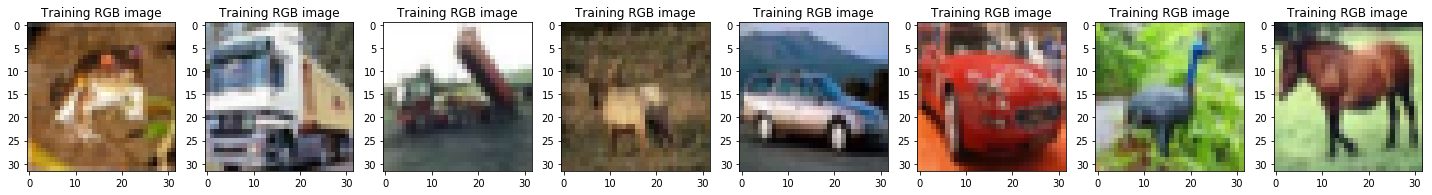

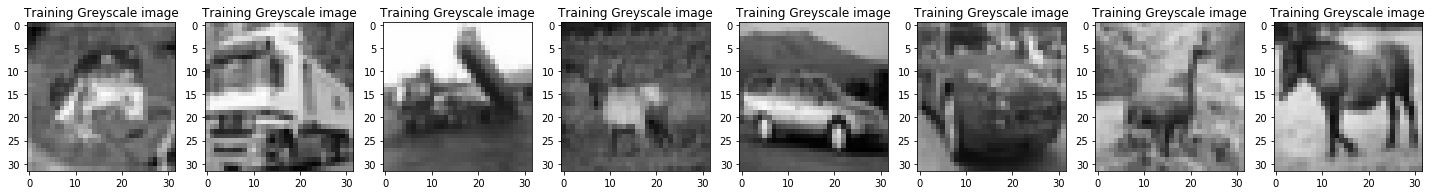

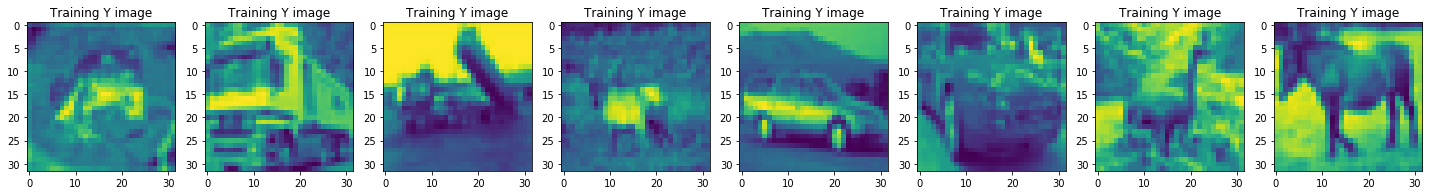

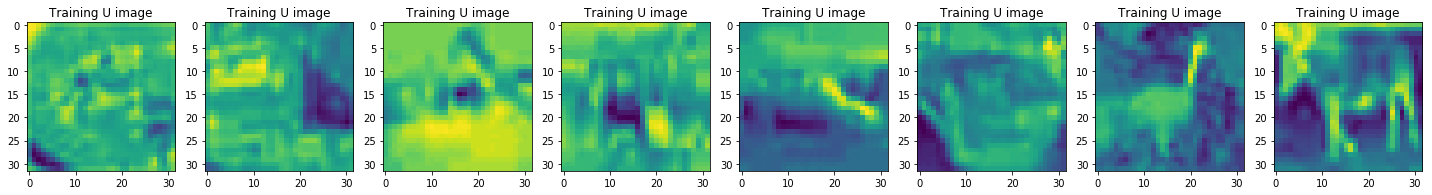

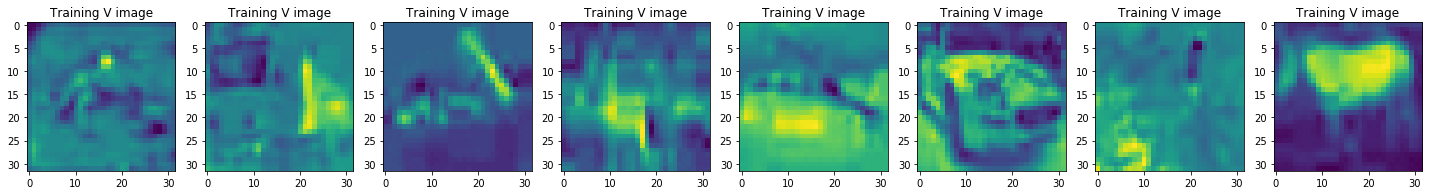

In [6]:
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training RGB image")
  plt.imshow(train_images[TRAINING_IMAGE+i])

fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training Greyscale image")
  plt.imshow((tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i])))

fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training Y image")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,0])
  
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training U image")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Training V image")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])

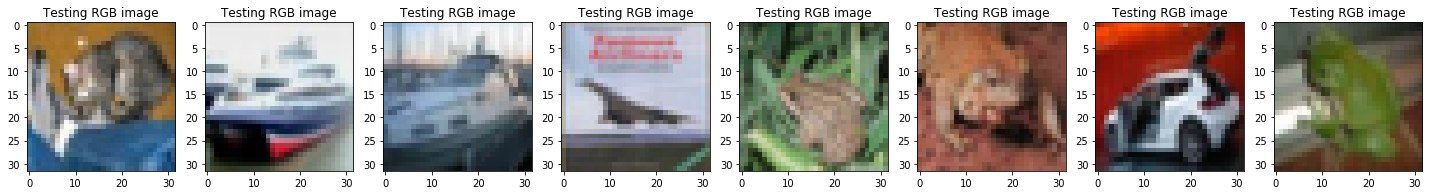

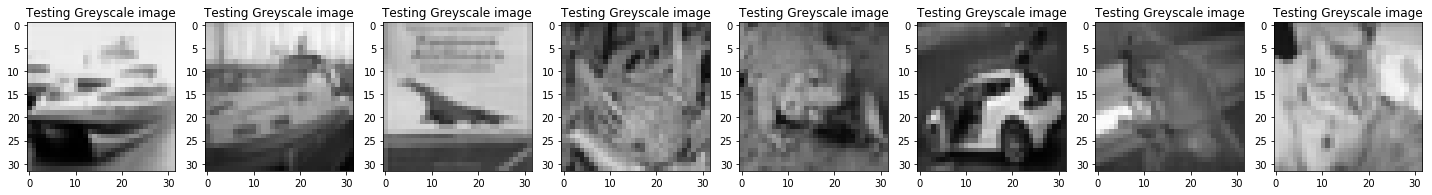

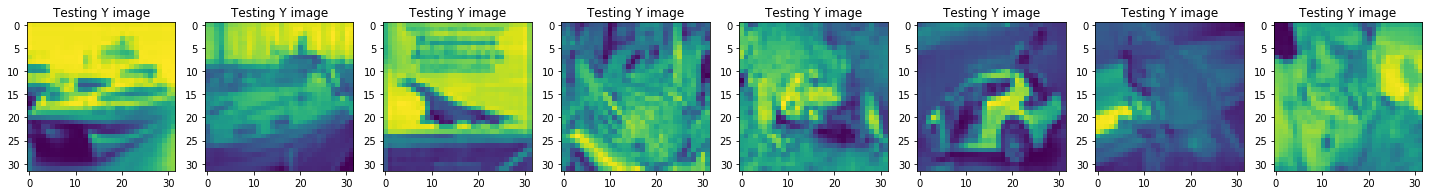

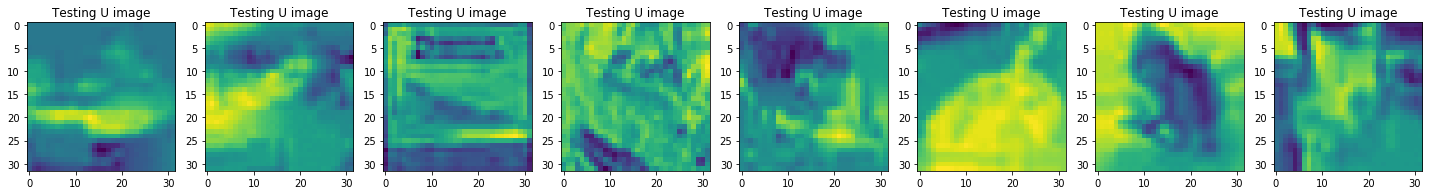

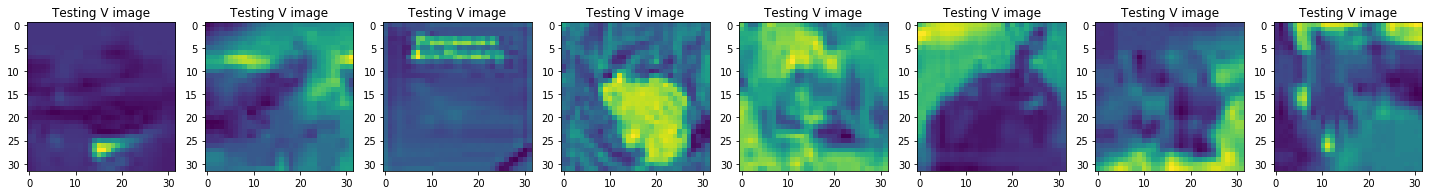

In [7]:
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing RGB image")
  plt.imshow(test_images[TRAINING_IMAGE+i])

fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing Greyscale image")
  plt.imshow((tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i])))

fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing Y image")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,0])
  
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing U image")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(25, 16))
for i in range(8):
  fig.add_subplot(1,8,i+1)
  plt.title("Testing V image")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,2])

# Create the Convolutional Neural Network

In [8]:
# Conv2D(filters (number of output filters)
#           - determine parameter number
#        kernel_size (size of convolution window)
#        activation (activation function to use)
#        padding ("valid" or "same")
#        strides (strides of the convolution along the height and width)
#           - strides greater than 1 will downsample
#        input_shape (only used on the first layer of the model))
#
# UpSampling2D(size (upsampling factors for rows and columns))

#https://github.com/emilwallner/Coloring-greyscale-images

# def create_model():
#   model = models.Sequential()
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
#   model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
#   model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
#   return model

def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(8, (4, 4), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(8, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(16, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(16, (4, 4), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=2))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(16, (4, 4), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (4, 4), activation='tanh', padding='same'))
  return model

create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 29, 29, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         4104      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 8)         1032      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 16)        2064      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 16)          4112      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          8224      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 32)          1

# Compile and Train the Model

In [9]:
# fit(x (input data)
#     y (target data)
#     batch_size (samples per gradient update)
#        - smaller batch size = more stochastic
#     epochs (epochs to train the model))


model = create_model()
model.compile(optimizer='rmsprop',
              loss='mse')

runtime_epochs = int(EPOCHS/4)
total_loss = []
total_val_loss = []

history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Train on 100 samples, validate on 100 samples
Epoch 1/100
100/100 [==============================] - 3s 28ms/sample - loss: 0.0050 - val_loss: 0.0037
Epoch 2/100
100/100 [==============================] - 0s 838us/sample - loss: 0.0049 - val_loss: 0.0036
Epoch 3/100
100/100 [==============================] - 0s 834us/sample - loss: 0.0049 - val_loss: 0.0036
Epoch 4/100
100/100 [==============================] - 0s 847us/sample - loss: 0.0049 - val_loss: 0.0037
Epoch 5/100
100/100 [==============================] - 0s 852us/sample - loss: 0.0049 - val_loss: 0.0036
Epoch 6/100
100/100 [==============================] - 0s 823us/sample - loss: 0.0048 - val_loss: 0.0486
Epoch 7/100
100/100 [==============================] - 0s 843us/sample - loss: 0.0176 - val_loss: 0.0036
Epoch 8/100
100/100 [==============================] - 0s 867us/sample - loss: 0.0048 - val_loss: 0.0037
Epoch 9/100
100/100 [==============================] - 0s 846us/sample - loss: 0.0048 - val_loss: 0.0037
Epoch 10/1

In [10]:
history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Train on 100 samples, validate on 100 samples
Epoch 1/100
100/100 [==============================] - 0s 923us/sample - loss: 0.0023 - val_loss: 0.0042
Epoch 2/100
100/100 [==============================] - 0s 811us/sample - loss: 0.0020 - val_loss: 0.0040
Epoch 3/100
100/100 [==============================] - 0s 804us/sample - loss: 0.0020 - val_loss: 0.0042
Epoch 4/100
100/100 [==============================] - 0s 864us/sample - loss: 0.0021 - val_loss: 0.0042
Epoch 5/100
100/100 [==============================] - 0s 841us/sample - loss: 0.0019 - val_loss: 0.0044
Epoch 6/100
100/100 [==============================] - 0s 811us/sample - loss: 0.0025 - val_loss: 0.0047
Epoch 7/100
100/100 [==============================] - 0s 782us/sample - loss: 0.0023 - val_loss: 0.0039
Epoch 8/100
100/100 [==============================] - 0s 817us/sample - loss: 0.0020 - val_loss: 0.0047
Epoch 9/100
100/100 [==============================] - 0s 825us/sample - loss: 0.0022 - val_loss: 0.0057
Epoch 10/

In [11]:
history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Train on 100 samples, validate on 100 samples
Epoch 1/100
100/100 [==============================] - 0s 895us/sample - loss: 9.4982e-04 - val_loss: 0.0044
Epoch 2/100
100/100 [==============================] - 0s 820us/sample - loss: 9.6057e-04 - val_loss: 0.0060
Epoch 3/100
100/100 [==============================] - 0s 827us/sample - loss: 0.0018 - val_loss: 0.0049
Epoch 4/100
100/100 [==============================] - 0s 822us/sample - loss: 0.0012 - val_loss: 0.0043
Epoch 5/100
100/100 [==============================] - 0s 814us/sample - loss: 7.5615e-04 - val_loss: 0.0043
Epoch 6/100
100/100 [==============================] - 0s 832us/sample - loss: 7.1661e-04 - val_loss: 0.0043
Epoch 7/100
100/100 [==============================] - 0s 790us/sample - loss: 9.6672e-04 - val_loss: 0.0041
Epoch 8/100
100/100 [==============================] - 0s 822us/sample - loss: 9.0978e-04 - val_loss: 0.0043
Epoch 9/100
100/100 [==============================] - 0s 800us/sample - loss: 7.5600e-04 

In [12]:
history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Train on 100 samples, validate on 100 samples
Epoch 1/100
100/100 [==============================] - 0s 1ms/sample - loss: 6.6395e-04 - val_loss: 0.0042
Epoch 2/100
100/100 [==============================] - 0s 946us/sample - loss: 5.5634e-04 - val_loss: 0.0042
Epoch 3/100
100/100 [==============================] - 0s 889us/sample - loss: 5.6840e-04 - val_loss: 0.0043
Epoch 4/100
100/100 [==============================] - 0s 936us/sample - loss: 6.6167e-04 - val_loss: 0.0043
Epoch 5/100
100/100 [==============================] - 0s 953us/sample - loss: 5.7681e-04 - val_loss: 0.0046
Epoch 6/100
100/100 [==============================] - 0s 923us/sample - loss: 7.2534e-04 - val_loss: 0.0043
Epoch 7/100
100/100 [==============================] - 0s 949us/sample - loss: 7.6457e-04 - val_loss: 0.0045
Epoch 8/100
100/100 [==============================] - 0s 939us/sample - loss: 6.4917e-04 - val_loss: 0.0041
Epoch 9/100
100/100 [==============================] - 0s 890us/sample - loss: 5.617

# Loss Function Results

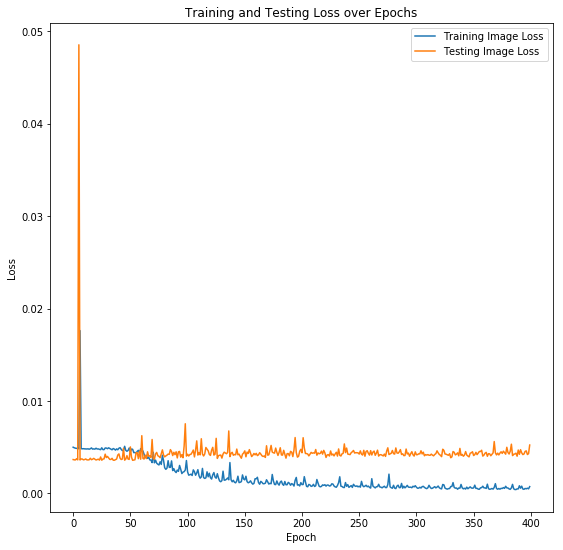

In [29]:
plt.figure(figsize=(9, 9))
plt.title("Training and Testing Loss over Epochs")
plt.plot(total_loss, label="Training Image Loss")
plt.plot(total_val_loss, label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training Results

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0010622620582580566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


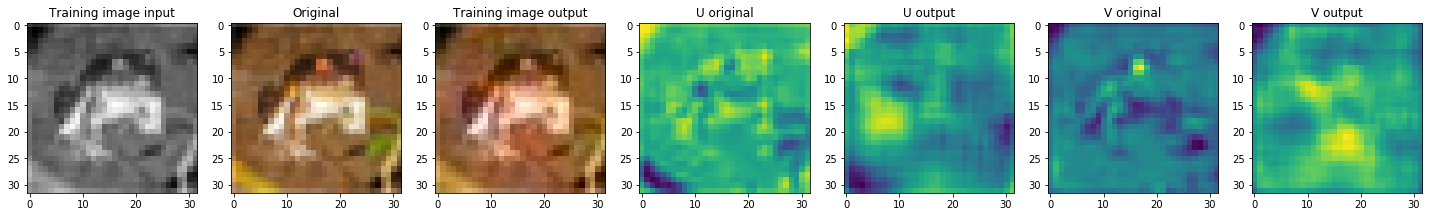

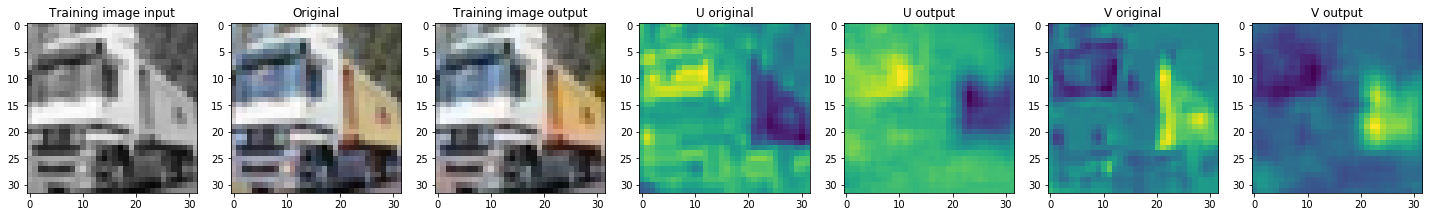

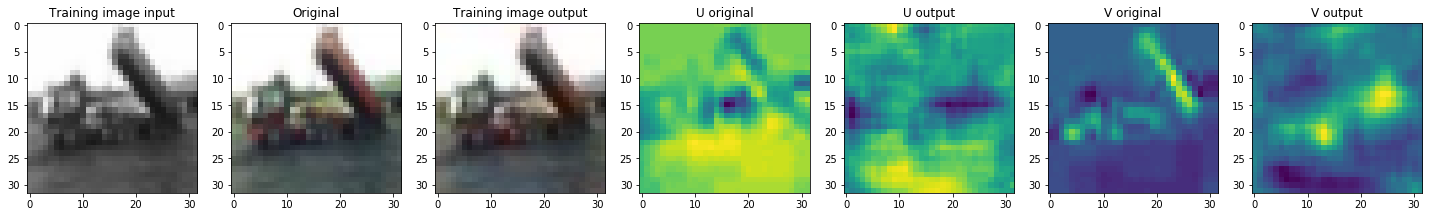

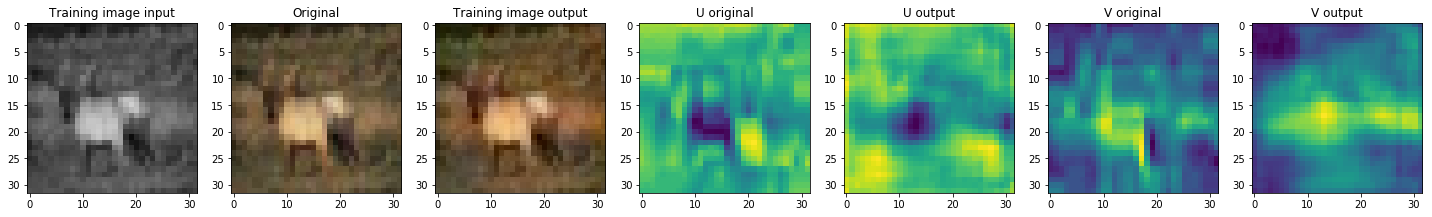

In [56]:
print(model.evaluate(train_y, train_uv, batch_size=BATCH_SIZE))
output = model.predict(train_y)
result = np.zeros((IMAGE_COUNT, 32, 32, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

for i in range(4):
  fig = plt.figure(figsize=(25, 16))
  fig.add_subplot(1,7,1)
  plt.title("Training image input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i]))
  fig.add_subplot(1,7,2)
  plt.title("Original")
  plt.imshow(train_images[TRAINING_IMAGE+i])
  fig.add_subplot(1,7,3)
  plt.title("Training image output")
  plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  fig.add_subplot(1,7,4)
  plt.title("U original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  fig.add_subplot(1,7,5)
  plt.title("U output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  fig.add_subplot(1,7,6)
  plt.title("V original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])
  fig.add_subplot(1,7,7)
  plt.title("V output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,2])

# Testing Results

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.005231269970536232


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


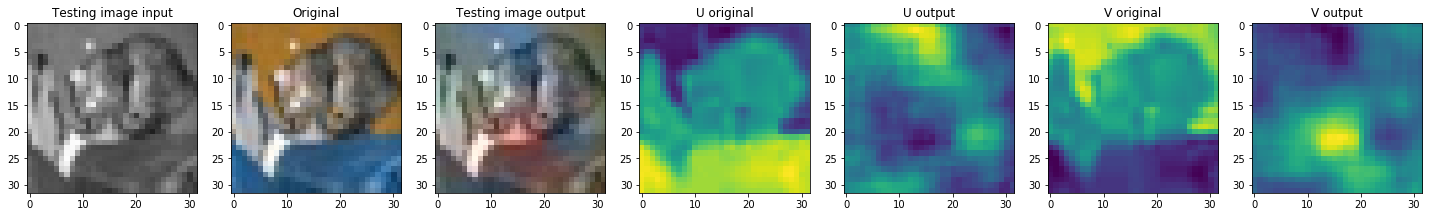

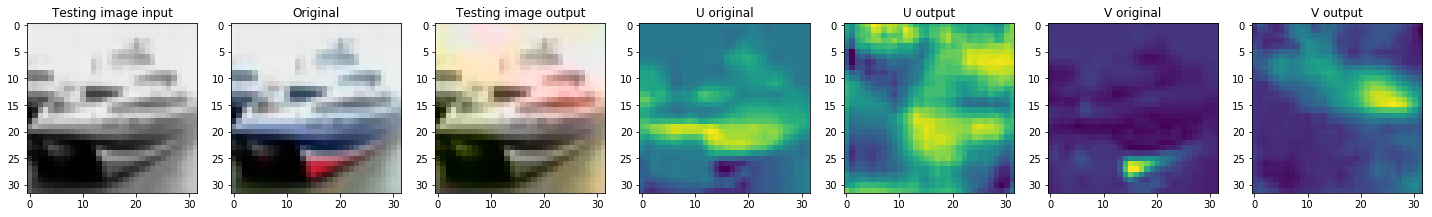

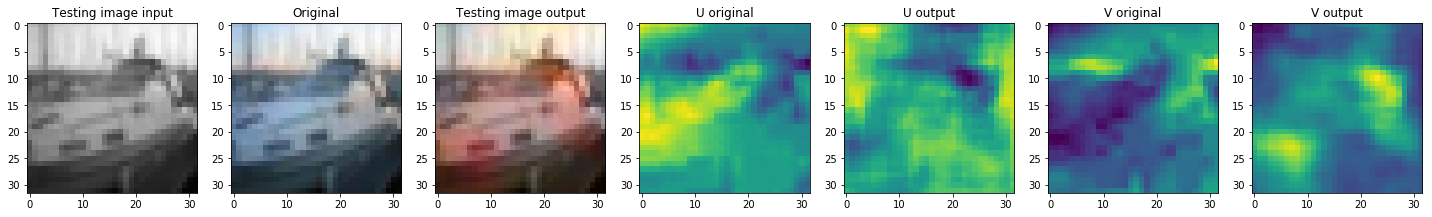

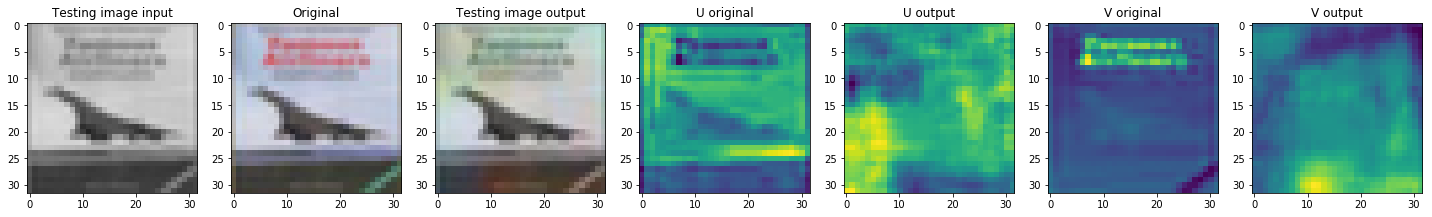

In [54]:
print(model.evaluate(test_y, test_uv, batch_size=BATCH_SIZE))
output = model.predict(test_y)
result = np.zeros((IMAGE_COUNT, 32, 32, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output

# plt.title("Testing image")
# plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE]))

# plt.figure()
# plt.title("Testing image converted back to RGB")
# plt.imshow(tf.image.yuv_to_rgb(result))

# plt.figure()
# plt.title("Original")
# plt.imshow(test_images[TEST_IMAGE])

# fig = plt.figure()
# fig.add_subplot(1,3,1)
# plt.title("Y original")
# plt.imshow(test_yuvImages[TEST_IMAGE,:,:,0])
# fig.add_subplot(1,3,2)
# plt.title("U original")
# plt.imshow(test_yuvImages[TEST_IMAGE,:,:,1])
# fig.add_subplot(1,3,3)
# plt.title("V original")
# plt.imshow(test_yuvImages[TEST_IMAGE,:,:,2])

# fig = plt.figure()
# fig.add_subplot(1,3,1)
# plt.title("Y result")
# plt.imshow(result[:,:,0])
# fig.add_subplot(1,3,2)
# plt.title("U result")
# plt.imshow(result[:,:,1])
# fig.add_subplot(1,3,3)
# plt.title("V result")
# plt.imshow(result[:,:,2])

for i in range(4):
  fig = plt.figure(figsize=(25, 16))
  fig.add_subplot(1,7,1)
  plt.title("Testing image input")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i]))
  fig.add_subplot(1,7,2)
  plt.title("Original")
  plt.imshow(test_images[TEST_IMAGE+i])
  fig.add_subplot(1,7,3)
  plt.title("Testing image output")
  plt.imshow(tf.image.yuv_to_rgb(result[TEST_IMAGE+i]))
  fig.add_subplot(1,7,4)
  plt.title("U original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,1])
  fig.add_subplot(1,7,5)
  plt.title("U output")
  plt.imshow(result[TEST_IMAGE+i,:,:,1])
  fig.add_subplot(1,7,6)
  plt.title("V original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,2])
  fig.add_subplot(1,7,7)
  plt.title("V output")
  plt.imshow(result[TEST_IMAGE+i,:,:,2])